_Навигационный список_

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

__Нужно:__

Загрузить и подготовить данные.

Обучить разные модели с различными гиперпараметрами.

Проанализировать скорость работы и качество моделей.

## Описание данных

Данные находятся в файле `/datasets/autos.csv.`

__Признаки__

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

__Целевой признак__

Price — цена (евро)

# Библиотеки

In [1]:
import pandas as pd
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor 
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV

## Комментарий наставника
<span style="color:green">Всё так, приступим к работе.</span>

___

# Проект

## 1. Подготовка данных

### Файл и беглый взгляд на данные

In [2]:
autos = pd.read_csv('/datasets/autos.csv')

In [3]:
autos.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf     150000                  0    petrol  volkswagen         NaN   
1    NaN     125000                  5  gasoline        audi         yes   
2  grand     125000                  8  gasoline        jeep         NaN   
3   golf     150000                  6    petrol  volkswagen          no   
4  fabia      90000                  7  gasoline       skoda          no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


### Микровывод

Имеется датасет на 354369 строк. Каждая строка- анкета на один автомобиль. Есть пропуски в NotRepaired, FuelType, Model, Gearbox, VehicleType.

Некоторые столбцы (признаки) для нашей задачи- задачи определения цены автомобиля- не нужны. Дропнем их.

Это столбцы:

`DateCrawled` — дата скачивания анкеты из базы

`RegistrationMonth` — месяц регистрации автомобиля

`DateCreated` — дата создания анкеты

`NumberOfPictures` — количество фотографий автомобиля

`PostalCode` — почтовый индекс владельца анкеты (пользователя)

`LastSeen` — дата последней активности пользователя

In [5]:
autos = (autos.drop(['DateCrawled','RegistrationMonth', 
               'DateCreated', 'NumberOfPictures',
               'PostalCode', 'LastSeen']
              , axis=1))

## Комментарий наставника
<span style="color:green">Полностью согласен с решением. От лишних признаков избавились.</span>

### Обработка пропусков
Посмотрим на уникальные значения в этих столбцах: не нужно ли объединить какие-то значения в одно?

`NotRepaired`

In [6]:
autos['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Может, NaN в этом столбце- то же самое, что no или yes. Посмотрим.

In [7]:
print('Среднее значение цены у машин без ответа на вопрос "был ли ремонт?":', autos.loc[autos['NotRepaired'].isna(), 'Price'].mean())

Среднее значение цены у машин без ответа на вопрос "был ли ремонт?": 2626.4192455800094


In [8]:
print('Среднее значение цены у машин с ремонтом:', autos.loc[autos['NotRepaired'] == 'no', 'Price'].mean())

Среднее значение цены у машин с ремонтом: 5296.811135251921


In [9]:
print('Среднее значение цены у машин без ремонта:', autos.loc[autos['NotRepaired'] == 'yes', 'Price'].mean())

Среднее значение цены у машин без ремонта: 1916.0390802684863


Средние значения целевого признака у 'no' и 'nan' различаются в два раза.

Зато у yes и NaN средние почти одинаковые. А стандартные отклонения?

In [10]:
print('Стандартное распределение цены у машин без ремонта:', autos.loc[autos['NotRepaired'] == 'yes', 'Price'].std())

Стандартное распределение цены у машин без ремонта: 2670.474425079957


In [11]:
print('Стандартное распределение цены у машин без ответа на вопрос "был ли ремонт?":', autos.loc[autos['NotRepaired'].isna(), 'Price'].std())

Стандартное распределение цены у машин без ответа на вопрос "был ли ремонт?": 3360.6124413447596


Распределения данных достаточно близки. Объединим NaN и yes

In [12]:
autos['NotRepaired'] = autos['NotRepaired'].fillna('yes')

## Комментарий наставника
<span style="color:green">Хорошо, вопросов нет.</span>

`FuelType`

In [13]:
autos['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Меньше 10% от всех данных имеют пропуски в этом столбце. Дропнем все.

In [14]:
autos = autos.dropna(subset=['FuelType'])

`Model`

Меньше 10% от всех данных имеют пропуски в этом столбце. Дропнем все.

In [15]:
autos = autos.dropna(subset=['Model'])

`VehicleType`

In [16]:
autos['VehicleType'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

Посмотрим на строки с пропусками подробнее.

In [17]:
autos.loc[autos['VehicleType'].isna()]

Price VehicleType  RegistrationYear Gearbox  Power      Model  \
0         480         NaN              1993  manual      0       golf   
16        300         NaN              2016     NaN     60       polo   
22       2900         NaN              2018  manual     90     meriva   
31        899         NaN              2016  manual     60       clio   
35        350         NaN              2016  manual     75       golf   
...       ...         ...               ...     ...    ...        ...   
354208   8700         NaN              2009     NaN      0    2_reihe   
354216    790         NaN              1990  manual      0      other   
354253   1250         NaN              2018     NaN      0      corsa   
354336   3299         NaN              2005    auto      0  outlander   
354364      0         NaN              2005  manual      0       colt   

        Kilometer FuelType       Brand NotRepaired  
0          150000   petrol  volkswagen         yes  
16         150000   petrol  volkswagen         yes  
22         150000   petrol        opel          no  
31         150000   petrol     renault         yes  
35         150000   petrol  volkswagen          no  
...           ...      ...         ...         ...  
354208      90000   petrol     peugeot         yes  
354216     150000   petrol     renault         yes  
354253     150000   petrol        opel         yes  
354336     150000   petrol  mitsubishi         yes  
354364     150000   petrol  mitsubishi         yes  

[17681 rows x 10 columns]

Машины разные, заполнять пропуски вручную- дело неблагородное, и, может быть, бессмысленное. Удалим пропуски, где они на всех строках, а то, что останется, кинем в 'other'. Так сохраним данные.

In [18]:
autos['VehicleType'] = autos['VehicleType'].fillna('other')

## Комментарий наставника
<span style="color:green">Можно и так.</span>

`Gearbox`

In [19]:
autos['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Попробуем избавиться от NaN в столбце Gearbox без удаления стобцов. Как ведёт себя распределение цен в зависимости от типа коробки передач?

`auto`

In [20]:
print('Среднее', autos.loc[(autos['Gearbox'] == 'auto'), 'Price'].mean())
print('Стандартное отклонение', autos.loc[(autos['Gearbox'] == 'auto'), 'Price'].std())

Среднее 7038.204082653725
Стандартное отклонение 5398.506930227204


Без типа коробки передач (`Nan`)

In [21]:
print('Среднее', autos.loc[autos['Gearbox'].isna(), 'Price'].mean())
print('Стандартное отклонение', autos.loc[autos['Gearbox'].isna(), 'Price'].std())

Среднее 2701.428586150041
Стандартное отклонение 3046.0753630596464


С любым из двух (`auto`, `manual`) значений

In [22]:
print('Среднее', autos.loc[autos['Gearbox'].notna(), 'Price'].mean())
print('Стандартное отклонение', autos.loc[autos['Gearbox'].notna(), 'Price'].std())

Среднее 4743.268190142634
Стандартное отклонение 4604.410858043635


`manual`

In [23]:
print('Среднее', autos.loc[(autos['Gearbox'] == 'manual'), 'Price'].mean())
print('Стандартное отклонение', autos.loc[(autos['Gearbox'] == 'manual'), 'Price'].std())

Среднее 4168.150639244024
Стандартное отклонение 4190.4032659137


Никаких способов "спасти" отсутствующие значения в столбцах Gearbox нет, связей между Nan и другими не прослеживается. Дропнем строки с пропусками.

In [24]:
autos = autos.dropna(subset=['Gearbox'])

Информация о датасете после обработки пропусков

In [25]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299228 entries, 0 to 354368
Data columns (total 10 columns):
Price               299228 non-null int64
VehicleType         299228 non-null object
RegistrationYear    299228 non-null int64
Gearbox             299228 non-null object
Power               299228 non-null int64
Model               299228 non-null object
Kilometer           299228 non-null int64
FuelType            299228 non-null object
Brand               299228 non-null object
NotRepaired         299228 non-null object
dtypes: int64(4), object(6)
memory usage: 25.1+ MB


### Микровывод

В ходе обработки пропусков в данных было отброшено 15% данных. Зато данные стали чистыми и доступными к использованию и обработке.

___

### Завершение предобработки

In [26]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299228 entries, 0 to 354368
Data columns (total 10 columns):
Price               299228 non-null int64
VehicleType         299228 non-null object
RegistrationYear    299228 non-null int64
Gearbox             299228 non-null object
Power               299228 non-null int64
Model               299228 non-null object
Kilometer           299228 non-null int64
FuelType            299228 non-null object
Brand               299228 non-null object
NotRepaired         299228 non-null object
dtypes: int64(4), object(6)
memory usage: 25.1+ MB


In [27]:
autos

Price  VehicleType  RegistrationYear Gearbox  Power        Model  \
0         480        other              1993  manual      0         golf   
2        9800          suv              2004    auto    163        grand   
3        1500        small              2001  manual     75         golf   
4        3600        small              2008  manual     69        fabia   
5         650        sedan              1995  manual    102          3er   
...       ...          ...               ...     ...    ...          ...   
354363   1150          bus              2000  manual      0       zafira   
354364      0        other              2005  manual      0         colt   
354366   1199  convertible              2000    auto    101       fortwo   
354367   9200          bus              1996  manual    102  transporter   
354368   3400        wagon              2002  manual    100         golf   

        Kilometer  FuelType       Brand NotRepaired  
0          150000    petrol  volkswagen         yes  
2          125000  gasoline        jeep         yes  
3          150000    petrol  volkswagen          no  
4           90000  gasoline       skoda          no  
5          150000    petrol         bmw         yes  
...           ...       ...         ...         ...  
354363     150000    petrol        opel          no  
354364     150000    petrol  mitsubishi         yes  
354366     125000    petrol       smart          no  
354367     150000  gasoline  volkswagen          no  
354368     150000  gasoline  volkswagen         yes  

[299228 rows x 10 columns]

`RegistrationYear`

In [28]:
autos['RegistrationYear'].unique()

array([1993, 2004, 2001, 2008, 1995, 1980, 2014, 2005, 2011, 2007, 2009,
       2002, 2018, 1997, 1990, 1981, 2003, 2016, 1984, 2006, 1999, 1998,
       2017, 2012, 2010, 2000, 1992, 2013, 1994, 1991, 1996, 1989, 2015,
       1985, 1982, 1983, 1973, 1969, 1971, 1987, 1988, 1986, 1965, 1970,
       1945, 1974, 1955, 1978, 1976, 1979, 1972, 1977, 1961, 1966, 1975,
       1963, 1954, 1967, 1960, 1964, 1910, 1968, 1962, 1937, 1951, 1953,
       2019, 1959, 1958, 1956, 2900, 1400, 1950, 1200, 1932, 1952, 3700,
       5000, 1942, 1935, 6500, 1957, 1923, 1930, 1943, 1934, 1938, 9000,
       1936, 1000, 1919, 1929, 6000, 1928, 1931, 1927, 1933, 1947, 7500,
       1600])

В RegistrationYear удаляем неадекватные данные годов выпуска. Делаем срез с 1950 по 2017 годы.

In [29]:
autos = autos.where(autos['RegistrationYear'] <= 2016) 
autos = autos.where(autos['RegistrationYear'] >= 1950)

`Power`

Построим ящик с усами.

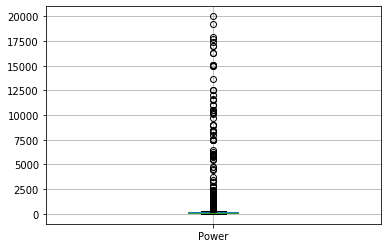

In [30]:
autos.boxplot(column='Power')
#plt.show()

Имеется много выбросов. Отбросим, для начала, верхний ус. Мощность двигателя болида команды "Мерседес" в серии Гран При 'Formula 1' в этом году- 1000 лошадиных сил. Отбросим всё, у чего мощность больше 500.

In [31]:
autos = autos.where(autos['Power'] <= 500) 

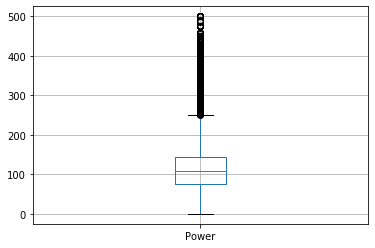

In [32]:
autos.boxplot(column='Power')
#plt.show()

Обросим нижний ус. Убёрем всё, что ниже 50 л.с.

In [33]:
autos = autos.where(autos['Power'] >= 50)

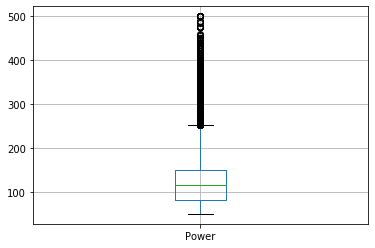

In [34]:
autos.boxplot(column='Power')

Оставим пока вот так.

`Kilometer`

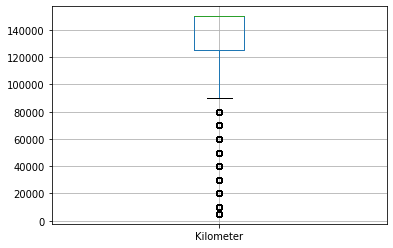

In [35]:
autos.boxplot(column = 'Kilometer')

Данные от нуля до 140000 км. Ничего выделяющегося нет. Оставляем, как есть.

### Микровывод

По столбцам с километражем, мощностями и годом регистрации автомобиля оставили только данные, нужные рынку: избавились от выбросов и артефактов.

### Целевой признак

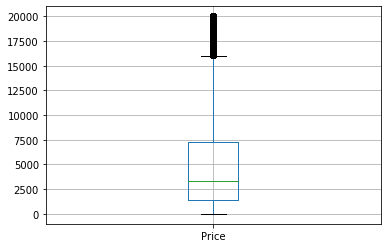

In [36]:
autos.boxplot(column = 'Price')

Автомобиль с ценой в евро должен стоить от 150 евро минимум. Отбросим всё, что меньше.

In [37]:
autos = autos.where(autos['Price'] >= 150) 

Дропаем строчки, которые получились в результате отсечения мощностей и годов выпуска.

In [38]:
autos = autos.dropna(how='all')

Пересоберём индексы

In [39]:
autos = autos.reset_index(drop = True)

__Получилось вот так:__

In [40]:
autos

Price  VehicleType  RegistrationYear Gearbox  Power        Model  \
0       9800.0          suv            2004.0    auto  163.0        grand   
1       1500.0        small            2001.0  manual   75.0         golf   
2       3600.0        small            2008.0  manual   69.0        fabia   
3        650.0        sedan            1995.0  manual  102.0          3er   
4       2200.0  convertible            2004.0  manual  109.0      2_reihe   
...        ...          ...               ...     ...    ...          ...   
263173  7900.0        sedan            2010.0  manual  140.0         golf   
263174  3200.0        sedan            2004.0  manual  225.0         leon   
263175  1199.0  convertible            2000.0    auto  101.0       fortwo   
263176  9200.0          bus            1996.0  manual  102.0  transporter   
263177  3400.0        wagon            2002.0  manual  100.0         golf   

        Kilometer  FuelType       Brand NotRepaired  
0        125000.0  gasoline        jeep         yes  
1        150000.0    petrol  volkswagen          no  
2         90000.0  gasoline       skoda          no  
3        150000.0    petrol         bmw         yes  
4        150000.0    petrol     peugeot          no  
...           ...       ...         ...         ...  
263173   150000.0  gasoline  volkswagen          no  
263174   150000.0    petrol        seat         yes  
263175   125000.0    petrol       smart          no  
263176   150000.0  gasoline  volkswagen          no  
263177   150000.0  gasoline  volkswagen         yes  

[263178 rows x 10 columns]

Категориальные переменные закодируем

In [41]:
# Для линейной регрессии
autos_per_regression = autos

In [42]:
autos_per_regression = pd.get_dummies(autos_per_regression, drop_first = True)

In [43]:
autos_per_regression

Price  RegistrationYear  Power  Kilometer  VehicleType_convertible  \
0       9800.0            2004.0  163.0   125000.0                        0   
1       1500.0            2001.0   75.0   150000.0                        0   
2       3600.0            2008.0   69.0    90000.0                        0   
3        650.0            1995.0  102.0   150000.0                        0   
4       2200.0            2004.0  109.0   150000.0                        1   
...        ...               ...    ...        ...                      ...   
263173  7900.0            2010.0  140.0   150000.0                        0   
263174  3200.0            2004.0  225.0   150000.0                        0   
263175  1199.0            2000.0  101.0   125000.0                        1   
263176  9200.0            1996.0  102.0   150000.0                        0   
263177  3400.0            2002.0  100.0   150000.0                        0   

        VehicleType_coupe  VehicleType_other  VehicleType_sedan  \
0                       0                  0                  0   
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  1   
4                       0                  0                  0   
...                   ...                ...                ...   
263173                  0                  0                  1   
263174                  0                  0                  1   
263175                  0                  0                  0   
263176                  0                  0                  0   
263177                  0                  0                  0   

        VehicleType_small  VehicleType_suv  ...  Brand_seat  Brand_skoda  \
0                       0                1  ...           0            0   
1                       1                0  ...           0            0   
2                       1                0  ...           0            1   
3                       0                0  ...           0            0   
4                       0                0  ...           0            0   
...                   ...              ...  ...         ...          ...   
263173                  0                0  ...           0            0   
263174                  0                0  ...           1            0   
263175                  0                0  ...           0            0   
263176                  0                0  ...           0            0   
263177                  0                0  ...           0            0   

        Brand_smart  Brand_subaru  Brand_suzuki  Brand_toyota  Brand_trabant  \
0                 0             0             0             0              0   
1                 0             0             0             0              0   
2                 0             0             0             0              0   
3                 0             0             0             0              0   
4                 0             0             0             0              0   
...             ...           ...           ...           ...            ...   
263173            0             0             0             0              0   
263174            0             0             0             0              0   
263175            1             0             0             0              0   
263176            0             0             0             0              0   
263177            0             0             0             0              0   

        Brand_volkswagen  Brand_volvo  NotRepaired_yes  
0                      0            0                1  
1                      1            0                0  
2                      0            0                0  
3                      0            0                1  
4                      0            0                0  
...                  ...          ...  

In [44]:
encoder = OrdinalEncoder()
autos[["VehicleType","Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]] = (encoder.fit_transform(autos[["VehicleType","Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]]))

## Вывод по подготовке

- __Имеется датасет__ на 354369 строк. Каждая строка- анкета на один автомобиль. Есть пропуски в NotRepaired, FuelType, Model, Gearbox, VehicleType.

Некоторые столбцы (признаки) для нашей задачи- задачи определения цены автомобиля- не нужны. Дропнем их.

Это столбцы:

`DateCrawled` — дата скачивания анкеты из базы

`RegistrationMonth` — месяц регистрации автомобиля

`DateCreated` — дата создания анкеты

`NumberOfPictures` — количество фотографий автомобиля

`PostalCode` — почтовый индекс владельца анкеты (пользователя)

`LastSeen` — дата последней активности пользователя

- __В ходе обработки пропусков__ в данных было отброшено 15% данных. Зато данные стали чистыми и доступными к использованию и обработке.

- __По столбцам с километражем, мощностями и годом регистрации__ автомобиля оставили только данные, нужные рынку: избавились от выбросов и артефактов. Отбросили ещё данных, в том числе сроки с машинами дешевле 150 евро. В общей сложности отброшено 24% данных- много, но не критично. Они не отвечают задачам бизнеса и только мешали бы при построении модели.

- Закодировали категориальные переменные с помощью OrdinalEncoder()


Можно приступать к обучению моделей.

___

## 2. Обучение моделей

### Выборки

Выделим целевой признак.

In [45]:
features = autos.drop(columns = ['Price'])
target = autos['Price']

Разделение датасета на выборки. Разделим на тестовую, валидационную и обучающую выборки в отношении 3:1:1.

In [46]:
features_train, features_for_division, target_train, target_for_division = train_test_split(features, target, test_size = 0.4)

Проверка правильного разбиения

In [47]:
print(features_train.shape)
print(features_for_division.shape)
print(target_train.shape)
print(target_for_division.shape)

(157906, 9)
(105272, 9)
(157906,)
(105272,)


In [48]:
features_test, features_valid, target_test, target_valid = train_test_split(features_for_division, target_for_division, test_size = 0.5)

Проверка правильного разбиения

In [49]:
print(features_test.shape)
print(features_valid.shape)
print(target_test.shape)
print(target_valid.shape)

(52636, 9)
(52636, 9)
(52636,)
(52636,)


### Микровывод

Разделили датасета на выборки: на тестовую, валидационную и обучающую выборки в отношении 3:1:1.

Валидационную создали для решения дальнейших задач- показать начальству или что-то в этом жанре. При анализе моделей её использовать не будем.

# Features, target для LR

In [50]:
features_reg = autos_per_regression.drop(columns = ['Price'])
target_reg = autos_per_regression['Price']

features_train_reg, features_for_division_reg, target_train_reg, target_for_division_reg = train_test_split(
    features_reg, target_reg, test_size = 0.4)

features_test_reg, features_valid_reg, target_test_reg, target_valid_reg = train_test_split(
    features_for_division_reg, target_for_division_reg, test_size = 0.5)

### Линейная регрессия

In [51]:
%%time
LR_model = LinearRegression(normalize=True)
LR_model.fit(features_train_reg, target_train_reg)
LR_predict = LR_model.predict(features_test_reg)
print('RMSE:', mean_squared_error(target_test_reg, LR_predict) **0.5)

RMSE: 2500.1041397041486
CPU times: user 13.9 s, sys: 5.87 s, total: 19.8 s
Wall time: 19.8 s


### Случайный лес

Подберём гиперпараметры с GridSearch

In [49]:

RFR_model=RandomForestRegressor(random_state=42)
param_grid = { 
    'n_estimators': [10, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6]
}
CV_rfr = GridSearchCV(estimator=RFR_model, param_grid=param_grid, cv= 5, verbose = 3)

CV_rfr.fit(features_train, target_train)
print(CV_rfr.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=4, max_features=auto, n_estimators=10 .................
[CV]  max_depth=4, max_features=auto, n_estimators=10, score=0.695, total=   0.6s
[CV] max_depth=4, max_features=auto, n_estimators=10 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=4, max_features=auto, n_estimators=10, score=0.695, total=   0.6s
[CV] max_depth=4, max_features=auto, n_estimators=10 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=4, max_features=auto, n_estimators=10, score=0.694, total=   0.6s
[CV] max_depth=4, max_features=auto, n_estimators=10 .................
[CV]  max_depth=4, max_features=auto, n_estimators=10, score=0.697, total=   0.6s
[CV] max_depth=4, max_features=auto, n_estimators=10 .................
[CV]  max_depth=4, max_features=auto, n_estimators=10, score=0.697, total=   0.6s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................
[CV]  max_depth=4, max_features=auto, n_estimators=100, score=0.696, total=   6.1s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................
[CV]  max_depth=4, max_features=auto, n_estimators=100, score=0.695, total=   6.2s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................
[CV]  max_depth=4, max_features=auto, n_estimators=100, score=0.695, total=   6.6s
[CV] max_depth=4, max_features=auto, n_estimators=100 ................
[CV]  max_depth=4, max_features=auto, n_estimators=100, score=0.699, total=   6

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.8min finished


{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}


Модель

In [50]:
%%time
RF_model = RandomForestRegressor(max_depth=6, max_features='sqrt', n_estimators=100, random_state = 42)
RF_model.fit(features_train, target_train)
RF_model_predict = RF_model.predict(features_test)
print('RMSE:', mean_squared_error(target_test, RF_model_predict)**0.5)

RMSE: 2168.574520731342
Wall time: 4.93 s


### Catboost

Подбор гиперпараметров

In [52]:
%%time
CB_model = CatBoostRegressor()
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [5, 7, 9],
        'iterations': [10, 100, 1000]}

CV_model = GridSearchCV(estimator=CB_model, param_grid=grid, cv= 5)

CV_model.fit(features_train, target_train)
print(CV_model.best_params_)

0:	learn: 4564.5867636	total: 60.5ms	remaining: 545ms
1:	learn: 4483.3702951	total: 66.7ms	remaining: 267ms
2:	learn: 4404.9764356	total: 73.1ms	remaining: 170ms
3:	learn: 4327.9455623	total: 79.1ms	remaining: 119ms
4:	learn: 4253.1738006	total: 85.1ms	remaining: 85.1ms
5:	learn: 4183.1321732	total: 91.3ms	remaining: 60.9ms
6:	learn: 4111.7648812	total: 97.2ms	remaining: 41.6ms
7:	learn: 4046.1471345	total: 103ms	remaining: 25.8ms
8:	learn: 3981.9374659	total: 109ms	remaining: 12.2ms
9:	learn: 3919.6168393	total: 115ms	remaining: 0us
0:	learn: 4572.0741122	total: 7.85ms	remaining: 70.7ms
1:	learn: 4490.9736534	total: 14.1ms	remaining: 56.4ms
2:	learn: 4412.7528950	total: 20.5ms	remaining: 47.9ms
3:	learn: 4335.6271610	total: 26.7ms	remaining: 40.1ms
4:	learn: 4262.0720832	total: 32.8ms	remaining: 32.8ms
5:	learn: 4191.7404357	total: 39.2ms	remaining: 26.1ms
6:	learn: 4120.4278514	total: 45.1ms	remaining: 19.3ms
7:	learn: 4051.4142865	total: 51ms	remaining: 12.8ms
8:	learn: 3988.3931134

Модель

In [60]:
%%time
CB_model = CatBoostRegressor(objective = "RMSE", iterations=1000, depth=10, l2_leaf_reg=5, learning_rate=0.1)
CB_model.fit(features_train, target_train)
CB_model_prediction = CB_model.predict(features_test)
print("RMSE:", mean_squared_error(target_test, CB_model_prediction)**0.5)

0:	learn: 4322.1340900	total: 29.7ms	remaining: 29.7s
1:	learn: 4024.9785638	total: 57.4ms	remaining: 28.6s
2:	learn: 3759.4798986	total: 83ms	remaining: 27.6s
3:	learn: 3527.8262995	total: 108ms	remaining: 26.8s
4:	learn: 3323.5791077	total: 133ms	remaining: 26.6s
5:	learn: 3141.8299041	total: 157ms	remaining: 26.1s
6:	learn: 2985.4317240	total: 182ms	remaining: 25.8s
7:	learn: 2846.8184568	total: 207ms	remaining: 25.7s
8:	learn: 2728.0788684	total: 232ms	remaining: 25.5s
9:	learn: 2622.6910949	total: 259ms	remaining: 25.6s
10:	learn: 2530.6900227	total: 284ms	remaining: 25.5s
11:	learn: 2447.5367040	total: 308ms	remaining: 25.4s
12:	learn: 2374.5548001	total: 333ms	remaining: 25.3s
13:	learn: 2313.2986451	total: 357ms	remaining: 25.1s
14:	learn: 2259.0862729	total: 382ms	remaining: 25.1s
15:	learn: 2210.5765110	total: 406ms	remaining: 24.9s
16:	learn: 2162.3737184	total: 430ms	remaining: 24.8s
17:	learn: 2126.1227743	total: 454ms	remaining: 24.8s
18:	learn: 2094.8920079	total: 481ms	

## Комментарий наставника
<span style="color:green">Очень хорошо.</span>

### LightBoost

In [57]:
%%time
LB_model = lgb.LGBMRegressor(num_boost_round=2000, learning_rate=0.01)
param_grid = {
    'num_leaves': [32, 64],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [10, 50, 100]
    }

gridSearchCV = GridSearchCV(estimator = LB_model, 
    param_grid = param_grid, 
    cv=5, verbose=2)

gridSearchCV.fit(features_train,target_train)

print(gridSearchCV.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1, total=  10.3s
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s
C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1, total=  10.4s
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1, total=  10.5s
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1, total=  10.7s
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.1, total=  10.6s
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5, total=  10.6s
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5, total=  10.8s
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5, total=  10.6s
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5, total=  10.5s
[CV] min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=32, reg_alpha=0.5, total=  10.5s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1, total=  13.5s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1, total=  13.4s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1, total=  13.4s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1, total=  13.3s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.1, total=  13.3s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5, total=  13.3s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5, total=  13.4s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5, total=  13.4s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5, total=  13.5s
[CV] min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=10, num_leaves=64, reg_alpha=0.5, total=  12.9s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1, total=  10.2s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1, total=  10.4s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1, total=  10.0s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1, total=  10.2s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.1, total=  10.3s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5, total=   9.9s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5, total=  10.3s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5, total=  10.3s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5, total=  10.1s
[CV] min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=32, reg_alpha=0.5, total=  10.5s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1, total=  13.7s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1, total=  13.4s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1, total=  13.2s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1, total=  13.5s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.1, total=  13.5s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5, total=  13.5s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5, total=  13.6s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5, total=  13.3s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5, total=  13.4s
[CV] min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5 ...............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=50, num_leaves=64, reg_alpha=0.5, total=  13.5s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1, total=  10.3s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1, total=  10.5s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1, total=  10.2s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1, total=  10.5s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.1, total=  10.4s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5, total=  10.4s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5, total=  10.4s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5, total=  10.5s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5, total=  10.5s
[CV] min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=32, reg_alpha=0.5, total=  10.7s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1, total=  13.5s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1, total=  13.4s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1, total=  13.6s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1, total=  13.7s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.1, total=  13.6s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5, total=  13.7s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5, total=  13.6s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5, total=  13.6s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5, total=  14.0s
[CV] min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5 ..............


C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  min_data_in_leaf=100, num_leaves=64, reg_alpha=0.5, total=  13.9s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.0min finished
C:\Users\Jan Krig\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


{'min_data_in_leaf': 10, 'num_leaves': 64, 'reg_alpha': 0.1}
Wall time: 12min 11s


Модель

In [62]:
%%time
LB_train = lgb.Dataset(features_train, label=target_train)
params = {
    'min_data_in_leaf': 10,
    'num_leaves': 64,
    'reg_alpha': 0.1,
}
LB_model = lgb.train(params, LB_train)

pred = LB_model.predict(features_test, num_iteration=LB_model.best_iteration)
print('RMSE', mean_squared_error(target_test, pred)**0.5)

RMSE 1609.0708045923259
Wall time: 1.05 s


## Вывод по обучению

Модели обучены, на обучение и подбор параметров уходит ощутимое количество времени. Можно приступить к анализу.

___

## 3. Анализ моделей

In [63]:
comparison = pd.DataFrame(
    {
        'RMSE': [mean_squared_error(target_test, LR_predict) **0.5,
                mean_squared_error(target_test, RF_model_predict)**0.5,
                mean_squared_error(target_test, CB_model_prediction)**0.5,
                mean_squared_error(target_test, pred)**0.5],
        'Time': ['5,73 s','4.93 s','25,6 s','1.05 s']
    },
    index = ['Linear Regression','RandomForest','Catboost','Lightboost']
)

In [64]:
comparison

RMSE     Time
Linear Regression  2876.051031  60.8 ms
RandomForest       2168.574521   4.93 s
Catboost           1523.174416   25,6 s
Lightboost         1609.070805   1.05 s

## Вывод по анализу

- __Linear Regression__ как всегда обеспечивает высочайшую скорость работы и, как часто, низкий результат. Самый высокий RMSE, __2876,051031__, время __5, 73 секунды__ Высокая скорость, низкое качество.

# С правильным кодированием скорость модели ожидаемо упала, при этом незначительно улучшился результат- с 2800 до 2500 по метрике RMSE. При этом время выросло и сравнялось со временем у случайного леса. Использовать Линейную регрессию смысла нет.

- __RandomForest__ показал более хороший результат по RMSE, но всё равно он замыкает тройку лучших. При этом время на порядки больше линейной регрессии. RMSE __2168.574521__, время __5 секунд__. Использовать его в данной задаче смысла нет - долго, а результат не оправдывает себя.

- __Catboost__ выдаёт самый лучший RMSE и самое долгое время обработки. Плюс затянутый подбор параметров, который на моём домашнем устройстве занял больше двадцати минут. RMSE __1523,174416__, время __25,6 секунд__

- __Lightboost__ сопоставимый с _catboost_ результат за гораздо меньшее время. RMSE __1609,070805__, время __1,05 секунд__.

<span style="color:blue">Оптимальным в данной задаче является использование Lightboost.</span>

___

# Общий вывод

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

- __Имеется датасет__ на 354369 строк. Каждая строка- анкета на один автомобиль. Есть пропуски в NotRepaired, FuelType, Model, Gearbox, VehicleType.

Некоторые столбцы (признаки) для нашей задачи- задачи определения цены автомобиля- не нужны. Дропнем их.

Это столбцы:

`DateCrawled` — дата скачивания анкеты из базы

`RegistrationMonth` — месяц регистрации автомобиля

`DateCreated` — дата создания анкеты

`NumberOfPictures` — количество фотографий автомобиля

`PostalCode` — почтовый индекс владельца анкеты (пользователя)

`LastSeen` — дата последней активности пользователя

- __В ходе обработки пропусков__ в данных было отброшено 15% данных. Зато данные стали чистыми и доступными к использованию и обработке.

- __По столбцам с километражем, мощностями и годом регистрации__ автомобиля оставили только данные, нужные рынку: избавились от выбросов и артефактов. Отбросили ещё данных, в том числе сроки с машинами дешевле 150 евро. В общей сложности отброшено 24% данных- много, но не критично. Они не отвечают задачам бизнеса и только мешали бы при построении модели.

- Закодировали категориальные переменные с помощью OrdinalEncoder()


Приступили к обучению моделей.

## Обучение

Разделили датасета на выборки: на тестовую, валидационную и обучающую выборки в отношении 3:1:1.

Валидационную создали для решения дальнейших задач- показать начальству или что-то в этом жанре. При анализе моделей её использовать не будем.

Модели обучены, на обучение и подбор параметров уходит ощутимое количество времени. Можно приступить к анализу.

## Анализ

- __Linear Regression__ как всегда обеспечивает высочайшую скорость работы и, как часто, низкий результат. Самый высокий RMSE, __2876,051031__, время __60,8 миллисекунд__ Высокая скорость, низкое качество.

- __RandomForest__ показал более хороший результат по RMSE, но всё равно он замыкает тройку лучших. При этом время на порядки больше линейной регрессии. RMSE __2168.574521__, время __5 секунд__. Использовать его в данной задаче смысла нет - долго, а результат не оправдывает себя.

- __Catboost__ выдаёт самый лучший RMSE и самое долгое время обработки. Плюс затянутый подбор параметров, который на моём домашнем устройстве занял больше двадцати минут. RMSE __1523,174416__, время __25,6 секунд__

- __Lightboost__ сопоставимый с _catboost_ результат за гораздо меньшее время. RMSE __1609,070805__, время __1,05 секунд__.

<span style="color:blue">Оптимальным в данной задаче является использование Lightboost.</span>

# Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей